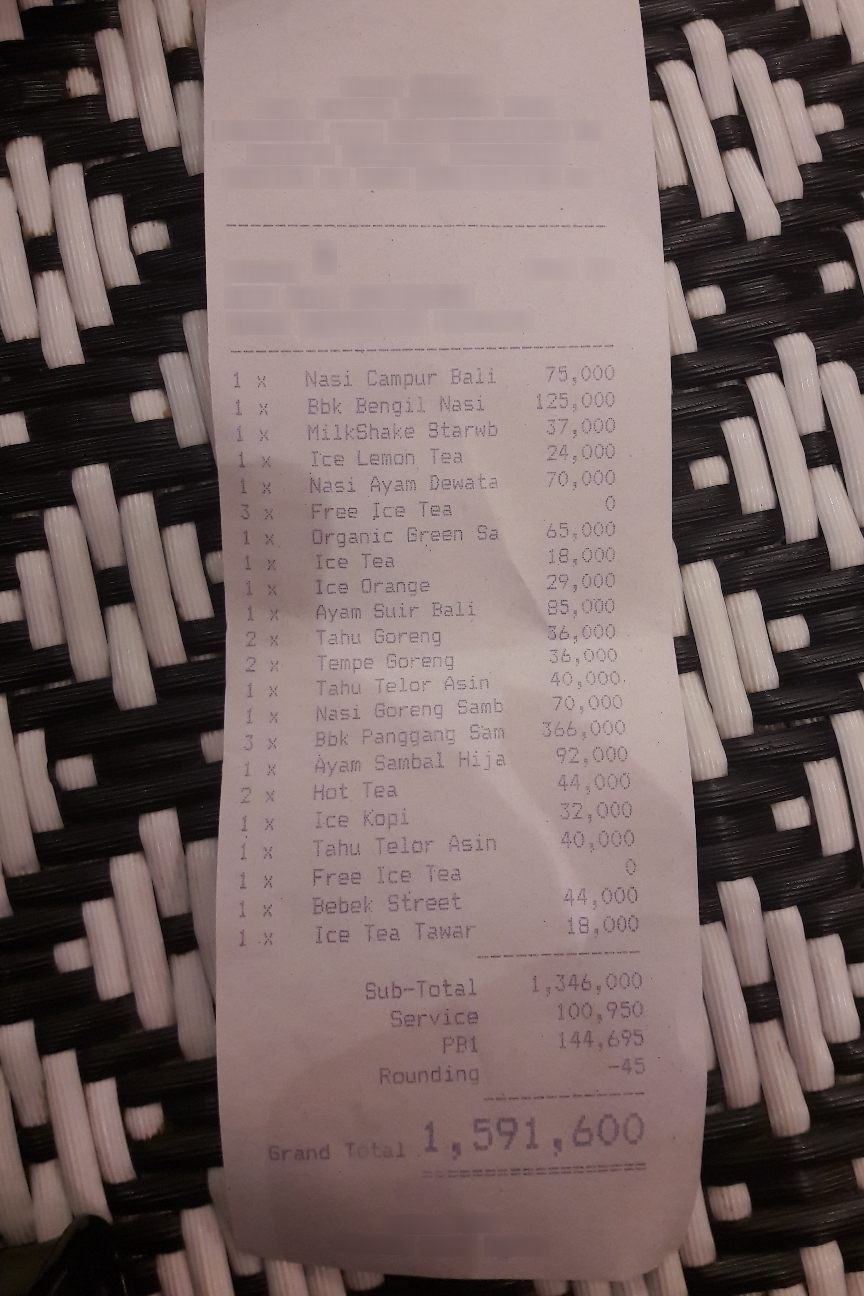

In [17]:
from PIL import Image

image = Image.open('/Users/andrejb/infra/shared/katana-git/sparrow/data/cord/CORD/train/image/receipt_00000.png')
image

In [18]:
import json

with open('/Users/andrejb/infra/shared/katana-git/sparrow/data/cord/CORD/train/json/receipt_00000.json') as json_file:
    data = json.load(json_file)

In [19]:
data.keys()

dict_keys(['dontcare', 'valid_line', 'meta', 'roi', 'repeating_symbol'])

In [20]:
data['meta']

{'version': 'v0.1',
 'split': 'train',
 'image_id': 0,
 'image_size': {'width': 864, 'height': 1296}}

In [21]:
data['roi']

{}

In [22]:
data['repeating_symbol']

[]

In [23]:
len(data['valid_line'])

93

In [24]:
data['valid_line'][0]

{'words': [{'quad': {'x2': 270,
    'y3': 390,
    'x3': 270,
    'y4': 390,
    'x1': 256,
    'y1': 374,
    'x4': 256,
    'y2': 374},
   'is_key': 0,
   'row_id': 2179893,
   'text': 'x'}],
 'category': 'menu.cnt',
 'group_id': 3}

In [25]:
import random

labels = ['menu.cnt',
 'menu.discountprice',
 'menu.etc',
 'menu.itemsubtotal',
 'menu.nm',
 'menu.num',
 'menu.price',
 'menu.sub_cnt',
 'menu.sub_etc',
 'menu.sub_nm',
 'menu.sub_price',
 'menu.sub_unitprice',
 'menu.unitprice',
 'menu.vatyn',
 'sub_total.discount_price',
 'sub_total.etc',
 'sub_total.othersvc_price',
 'sub_total.service_price',
 'sub_total.subtotal_price',
 'sub_total.tax_price',
 'total.cashprice',
 'total.changeprice',
 'total.creditcardprice',
 'total.emoneyprice',
 'total.menuqty_cnt',
 'total.menutype_cnt',
 'total.total_etc',
 'total.total_price',
 'void_menu.nm',
 'void_menu.price']

get_colors = lambda n: list(map(lambda i: "#" + "%06x" % random.randint(0, 0xFFFFFF),range(n)))
colors = get_colors(len(labels))
print(colors)

['#1a660f', '#397046', '#cc736b', '#46f4f5', '#28e372', '#74fede', '#f5b8b8', '#88e856', '#fc28df', '#78625f', '#a2b6c6', '#b59189', '#a606c9', '#bc0285', '#c01b29', '#2a8d53', '#d0826a', '#c2eb4d', '#4236d0', '#06abbd', '#b171ff', '#e37a4e', '#50d60d', '#ddc69f', '#71d5bf', '#f756a2', '#ffc129', '#e20782', '#e46259', '#bc8e71']


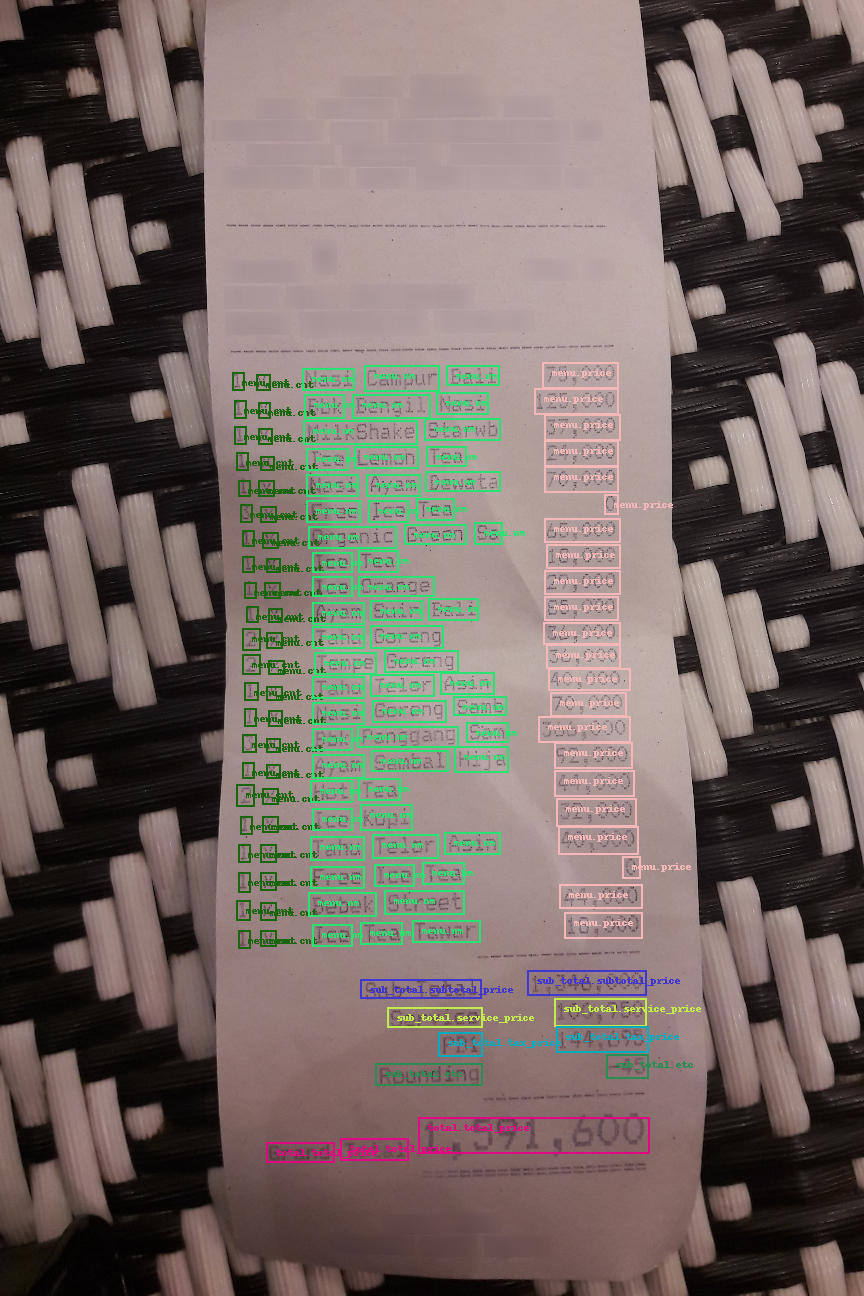

In [26]:
from PIL import ImageDraw, ImageFont

draw = ImageDraw.Draw(image, "RGBA")

font = ImageFont.load_default()

label2color = {label: colors[idx] for idx, label in enumerate(labels)}

for annotation in data['valid_line']:
  label = annotation['category']
  words = annotation['words']
  for word in words:
    coordinates = word['quad']
    x1, y1 = coordinates['x1'], coordinates['y1']
    x3, y3 = coordinates['x3'], coordinates['y3']
    box = [x1, y1, x3, y3]
    draw.rectangle(box, outline=label2color[label], width=2)
    draw.text((box[0]+10, box[1]+5), label, fill=label2color[label], font=font)

image

In [27]:
from tqdm.notebook import tqdm
import os

def normalize_bbox(bbox, width, height):
     return [
         int(1000 * (bbox[0] / width)),
         int(1000 * (bbox[1] / height)),
         int(1000 * (bbox[2] / width)),
         int(1000 * (bbox[3] / height)),
     ]

def generate_annotations(path: str):
  annotation_files = []
  for js in tqdm(os.listdir(path)):
    with open(path + js) as f:
        annotation_files.append(json.load(f))

  words = []
  boxes = []
  labels = []
  for js in tqdm(annotation_files):
      words_example = []
      boxes_example = []
      labels_example = []

      width, height = js['meta']['image_size']['width'], js['meta']['image_size']['height']
      # loop over OCR annotations
      for elem in js['valid_line']:
          for word in elem['words']:
              # get word
              txt = word['text']

              # get bounding box
              # important: each bounding box should be in (upper left, lower right) format
              # it took me some time to understand the upper left is (x1, y3)
              # and the lower right is (x3, y1)
              x1 = word['quad']['x1']
              y1 = word['quad']['y1']
              x3 = word['quad']['x3']
              y3 = word['quad']['y3']

              box = [x1, y1, x3, y3]
              box = normalize_bbox(box, width=width, height=height)

              # ADDED
              # skip empty word
              if len(txt) < 1:
                continue
              if min(box) < 0 or max(box) > 1000: # another bug in which a box had -4
                continue
              if ((box[3] - box[1]) < 0) or ((box[2] - box[0]) < 0): # another bug in which a box difference was -12
                continue
              # ADDED

              words_example.append(txt)
              boxes_example.append(box)
              labels_example.append(elem['category'])
      words.append(words_example)
      boxes.append(boxes_example)
      labels.append(labels_example)

  return words, boxes, labels

In [28]:
train_path = '/Users/andrejb/infra/shared/katana-git/sparrow/data/cord/CORD/train/json/'
val_path = '/Users/andrejb/infra/shared/katana-git/sparrow/data/cord/CORD/dev/json/'
test_path = '/Users/andrejb/infra/shared/katana-git/sparrow/data/cord/CORD/test/json/'

words_train, boxes_train, labels_train = generate_annotations(train_path)
words_val, boxes_val, labels_val = generate_annotations(val_path)
words_test, boxes_test, labels_test = generate_annotations(test_path)

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/800 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [29]:
labels_train[0]

['menu.nm',
 'menu.nm',
 'menu.cnt',
 'menu.price',
 'total.total_price',
 'total.total_price',
 'total.cashprice',
 'total.cashprice',
 'total.menuqty_cnt']

In [30]:
words_train[0]

['Tebu', 'Lemon', '1', '22.000', 'Total', '22.000', 'CASH', '22.000', '1']

In [31]:
boxes_train[0]

[[225, 563, 293, 587],
 [306, 562, 390, 587],
 [195, 564, 205, 587],
 [759, 557, 861, 584],
 [224, 623, 310, 669],
 [761, 622, 865, 670],
 [156, 707, 294, 751],
 [661, 704, 866, 755],
 [191, 625, 204, 671]]

In [32]:
import pickle
with open('/Users/andrejb/infra/shared/katana-git/sparrow/data/cord/out/train.pkl', 'wb') as t:
    pickle.dump([words_train, labels_train, boxes_train], t)
with open('/Users/andrejb/infra/shared/katana-git/sparrow/data/cord/out/dev.pkl', 'wb') as t:
    pickle.dump([words_val, labels_val, boxes_val], t)
with open('/Users/andrejb/infra/shared/katana-git/sparrow/data/cord/out/test.pkl', 'wb') as t:
    pickle.dump([words_test, labels_test, boxes_test], t)